In [28]:
import time 
import requests
import cv2
import operator
import numpy as np
from __future__ import print_function

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter

In [29]:
# Variables
_region = 'southcentralus' #Here you enter the region of your subscription
_url = 'https://{}.api.cognitive.microsoft.com/vision/v1.0/analyze'.format(_region)
_key = '533079e73b3e47a49a8d7f464aa77163' #Here you have to paste your primary key
_maxNumRetries = 10

In [30]:
def processRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json() ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json() ) )

        break
        
    return result

In [31]:
def renderResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""

    R = int(result['color']['accentColor'][:2],16)
    G = int(result['color']['accentColor'][2:4],16)
    B = int(result['color']['accentColor'][4:],16)

    cv2.rectangle( img,(0,0), (img.shape[1], img.shape[0]), color = (R,G,B), thickness = 25 )

    if 'categories' in result:
        categoryName = sorted(result['categories'], key=lambda x: x['score'])[0]['name']
        cv2.putText( img, categoryName, (30,70), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3 )

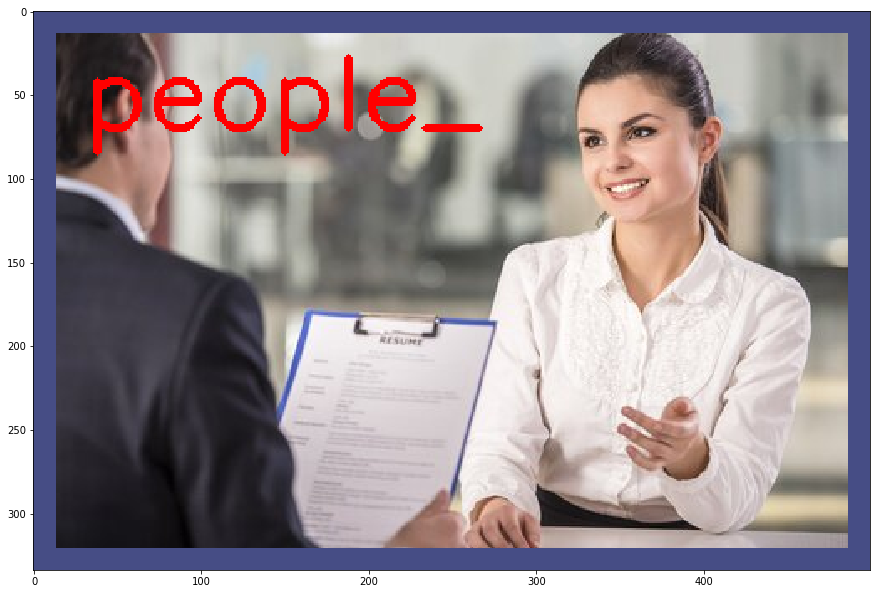

In [32]:
# URL direction to image
urlImage = 'https://lamenteesmaravillosa.com/wp-content/uploads/2016/10/Mujer-haciendo-una-entrevista-de-trabajo.jpg'

# Computer Vision parameters
params = { 'visualFeatures' : 'Color,Categories'} 

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json' 

json = { 'url': urlImage } 
data = None

result = processRequest( json, data, headers, params )

if result is not None:
    # Load the original image, fetched from the URL
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )